In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

#regression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from statistics import *
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

#clustering
import sklearn as skl
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn import metrics

!pip install statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf




In [2]:
prec = pd.read_csv('precipitacionsbarcelonadesde1786.csv')
prec.head()

,Any,Precip_Acum_Gener,Precip_Acum_Febrer,Precip_Acum_Marc,Precip_Acum_Abril,Precip_Acum_Maig,Precip_Acum_Juny,Precip_Acum_Juliol,Precip_Acum_Agost,Precip_Acum_Setembre,Precip_Acum_Octubre,Precip_Acum_Novembre,Precip_Acum_Desembre
0,1786,32.8,28.4,84.4,42.3,8.5,38.0,6.8,52.1,62.0,57.0,195.8,114.1
1,1787,136.4,27.4,44.6,76.9,0.0,29.8,34.7,14.9,205.8,12.4,42.2,0.0
2,1788,9.9,14.9,32.2,12.4,7.5,146.3,59.4,29.8,123.9,163.6,106.6,22.3
3,1789,12.4,12.4,23.6,9.9,32.2,9.9,6.3,69.4,18.7,52.1,18.7,76.9
4,1790,44.6,1.2,188.5,74.4,44.7,39.7,65.7,32.3,71.9,205.8,72.0,14.9


In [3]:
#rename columns
prec.rename(columns={'Precip_Acum_Gener': "1",
                   'Precip_Acum_Febrer': "2",
                   'Precip_Acum_Marc': "3",
                   'Precip_Acum_Abril': "4",
                   'Precip_Acum_Maig': "5",
                   'Precip_Acum_Juny': "6",
                   'Precip_Acum_Juliol': "7",
                   'Precip_Acum_Agost': "8",
                   'Precip_Acum_Setembre': "9",
                   'Precip_Acum_Octubre': "10",
                   'Precip_Acum_Novembre': "11",
                   'Precip_Acum_Desembre': "12"},inplace=True)

In [4]:
prec.columns

Index(['Any', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'], dtype='object')

<AxesSubplot:xlabel='Any'>

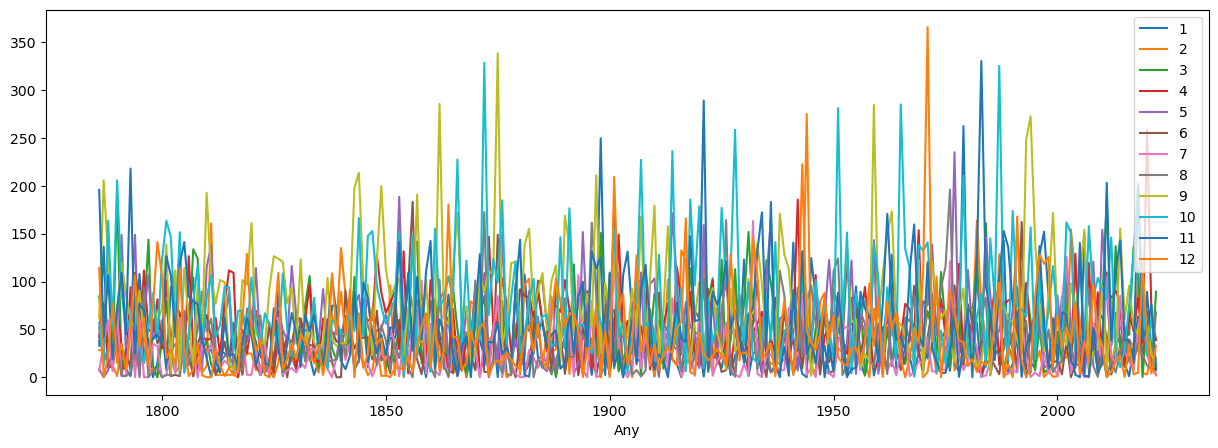

In [5]:
prec.plot(x= 'Any',figsize=(15, 5))

In [6]:
years = prec['Any'].unique()
df = pd.DataFrame(years, columns = ['Any'])
df['id'] = prec.index + 1
df.head(2)

,Any,id
0,1786,1
1,1787,2


In [7]:
df = prec.merge(df, how='left',on='Any')

In [8]:
df

,Any,1,2,3,4,5,6,7,8,9,10,11,12,id
0,1786,32.8,28.4,84.4,42.3,8.5,38.0,6.8,52.1,62.0,57.0,195.8,114.1,1
1,1787,136.4,27.4,44.6,76.9,0.0,29.8,34.7,14.9,205.8,12.4,42.2,0.0,2
2,1788,9.9,14.9,32.2,12.4,7.5,146.3,59.4,29.8,123.9,163.6,106.6,22.3,3
3,1789,12.4,12.4,23.6,9.9,32.2,9.9,6.3,69.4,18.7,52.1,18.7,76.9,4
4,1790,44.6,1.2,188.5,74.4,44.7,39.7,65.7,32.3,71.9,205.8,72.0,14.9,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232,2018,63.6,104.6,112.5,83.0,30.3,53.1,51.5,36.5,44.4,201.9,201.8,4.8,233
233,2019,18.2,4.6,0.3,36.2,109.0,19.3,75.8,23.1,71.5,83.2,39.4,119.2,234
234,2020,89.3,2.8,61.6,258.7,29.2,69.1,23.1,12.4,60.2,23.1,52.5,41.5,235
235,2021,26.2,26.5,7.7,62.7,13.4,7.8,9.0,8.3,23.3,63.2,75.9,3.8,236


<AxesSubplot:xlabel='Any'>

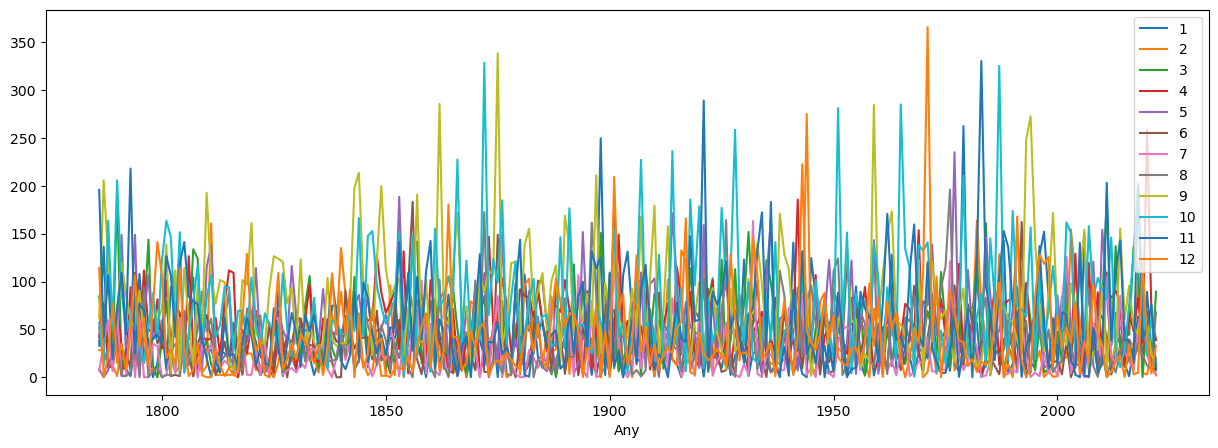

In [9]:
prec.plot(x= 'Any',figsize=(15, 5))

In [10]:
# Creates a pivot table dataframe
table = df.melt(id_vars=['Any', 'id'], value_vars=['1', '2', '3', '4', '5', '6', '7',
       '8', '9', '10', '11', '12'])


In [11]:
table.rename(columns = {'value': "Total_precipitació"})

,Any,id,variable,Total_precipitació
0,1786,1,1,32.8
1,1787,2,1,136.4
2,1788,3,1,9.9
3,1789,4,1,12.4
4,1790,5,1,44.6
...,...,...,...,...
2839,2018,233,12,4.8
2840,2019,234,12,119.2
2841,2020,235,12,41.5
2842,2021,236,12,3.8


In [12]:
# després de veure les cancel-lacions per mesos, cambio la data i utilitzo un datatime per unificar-la
table["Data"] = pd.to_datetime(dict(year=table["Any"], month=table["variable"], day="1"))


In [13]:
table

,Any,id,variable,value,Data
0,1786,1,1,32.8,1786-01-01
1,1787,2,1,136.4,1787-01-01
2,1788,3,1,9.9,1788-01-01
3,1789,4,1,12.4,1789-01-01
4,1790,5,1,44.6,1790-01-01
...,...,...,...,...,...
2839,2018,233,12,4.8,2018-12-01
2840,2019,234,12,119.2,2019-12-01
2841,2020,235,12,41.5,2020-12-01
2842,2021,236,12,3.8,2021-12-01


In [14]:
prom = table.groupby(['Any','variable']).mean()
prom

id  value
Any  variable              
1786 1           1.0   32.8
     10          1.0   57.0
     11          1.0  195.8
     12          1.0  114.1
     2           1.0   28.4
...              ...    ...
2022 5         237.0   20.0
     6         237.0    9.5
     7         237.0    2.7
     8         237.0   67.9
     9         237.0   13.1

[2844 rows x 2 columns]

<AxesSubplot:xlabel='Any', ylabel='value'>

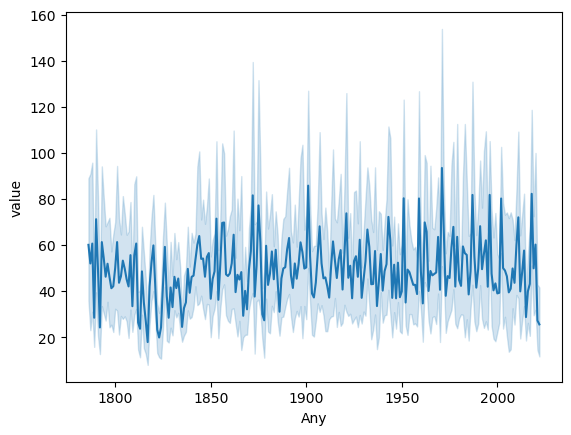

In [15]:
sns.lineplot(data=prom, x='Any', y='value')


In [16]:
temp = pd.read_csv('temperaturesbarcelonadesde1780.csv')
temp.head()

,Any,Temp_Mitjana_Gener,Temp_Mitjana_Febrer,Temp_Mitjana_Marc,Temp_Mitjana_Abril,Temp_Mitjana_Maig,Temp_Mitjana_Juny,Temp_Mitjana_Juliol,Temp_Mitjana_Agost,Temp_Mitjana_Setembre,Temp_Mitjana_Octubre,Temp_Mitjana_Novembre,Temp_Mitjana_Desembre
0,1786,7.8,8.3,9.9,12.8,16.8,20.2,20.9,21.1,19.5,15.5,9.2,8.3
1,1787,5.4,7.8,11.3,12.1,14.7,19.2,21.0,21.8,19.4,15.5,9.3,10.8
2,1788,6.4,10.1,10.4,12.5,17.1,19.2,22.1,23.0,19.1,15.5,10.5,5.4
3,1789,6.9,9.3,8.7,13.3,17.7,18.5,20.9,21.9,20.0,14.7,7.8,7.3
4,1790,7.4,9.5,10.4,12.3,15.0,19.0,20.8,23.1,19.3,17.1,11.7,7.9


In [17]:
#rename columns
temp.rename(columns={'Temp_Mitjana_Gener': "1",
                   'Temp_Mitjana_Febrer': "2",
                   'Temp_Mitjana_Marc': "3",
                   'Temp_Mitjana_Abril': "4",
                   'Temp_Mitjana_Maig': "5",
                   'Temp_Mitjana_Juny': "6",
                   'Temp_Mitjana_Juliol': "7",
                   'Temp_Mitjana_Agost': "8",
                   'Temp_Mitjana_Setembre': "9",
                   'Temp_Mitjana_Octubre': "10",
                   'Temp_Mitjana_Novembre': "11",
                   'Temp_Mitjana_Desembre': "12"},inplace=True)

In [18]:
years = temp['Any'].unique()
df = pd.DataFrame(years, columns = ['Any'])
df['id'] = prec.index + 1
df.head(2)

,Any,id
0,1786,1
1,1787,2


In [19]:
df1 = temp.merge(df, how='left',on='Any')
df

,Any,id
0,1786,1
1,1787,2
2,1788,3
3,1789,4
4,1790,5
...,...,...
232,2018,233
233,2019,234
234,2020,235
235,2021,236


In [20]:
# Creates a pivot table dataframe
table1 = df1.melt(id_vars=['Any','id'], value_vars=['1', '2', '3', '4', '5', '6', '7',
       '8', '9', '10', '11', '12'])

In [21]:
# després de veure les cancel-lacions per mesos, cambio la data i utilitzo un datatime per unificar-la
table1["Data"] = pd.to_datetime(dict(year=table1["Any"], month=table1["variable"], day="1"))

In [22]:
table1.rename(columns = {'value': "Total_temperatures"})

,Any,id,variable,Total_temperatures,Data
0,1786,1,1,7.8,1786-01-01
1,1787,2,1,5.4,1787-01-01
2,1788,3,1,6.4,1788-01-01
3,1789,4,1,6.9,1789-01-01
4,1790,5,1,7.4,1790-01-01
...,...,...,...,...,...
2839,2018,233,12,11.1,2018-12-01
2840,2019,234,12,11.2,2019-12-01
2841,2020,235,12,9.3,2020-12-01
2842,2021,236,12,10.9,2021-12-01


In [23]:
data = pd.merge(table1, table, on= ('id', 'variable', 'Any','Data'), how='outer')
data.head()

,Any,id,variable,value_x,Data,value_y
0,1786,1,1,7.8,1786-01-01,32.8
1,1787,2,1,5.4,1787-01-01,136.4
2,1788,3,1,6.4,1788-01-01,9.9
3,1789,4,1,6.9,1789-01-01,12.4
4,1790,5,1,7.4,1790-01-01,44.6


In [24]:
df_def = data.rename(columns={'value_x': "Temperatures", 'value_y':"Precipitacions", 'variable': "Mes"})

In [25]:
df_def.columns

Index(['Any', 'id', 'Mes', 'Temperatures', 'Data', 'Precipitacions'], dtype='object')

In [26]:
print(f'Número de filas con missing values: {df_def.isnull().any(axis=1).mean()}')

Número de filas con missing values: 0.0


In [27]:
df_def.dtypes

Any                        int64
id                         int64
Mes                       object
Temperatures             float64
Data              datetime64[ns]
Precipitacions           float64
dtype: object

In [28]:
df_def['Mes'] = df_def['Mes'].astype('int64')

In [29]:
df_def.sort_values(by='Temperatures',ascending=False)[['Any','Mes','Temperatures', 'Data']].head(10)

,Any,Mes,Temperatures,Data
1876,2003,8,28.5,2003-08-01
1895,2022,8,27.2,2022-08-01
1642,2006,7,27.1,2006-07-01
1658,2022,7,26.7,2022-07-01
1757,1884,8,26.4,1884-08-01
1882,2009,8,26.3,2009-08-01
1639,2003,7,26.1,2003-07-01
1885,2012,8,26.0,2012-08-01
1651,2015,7,26.0,2015-07-01
1630,1994,7,25.9,1994-07-01


In [30]:
df_def.sort_values(by='Precipitacions',ascending=False)[['Any','Mes','Precipitacions','Data']].head(10)

,Any,Mes,Precipitacions,Data
2792,1971,12,365.8,1971-12-01
1985,1875,9,338.5,1875-09-01
2567,1983,11,330.4,1983-11-01
2219,1872,10,328.6,1872-10-01
2334,1987,10,325.4,1987-10-01
2505,1921,11,289.2,1921-11-01
1972,1862,9,285.6,1862-09-01
2312,1965,10,285.1,1965-10-01
2069,1959,9,284.5,1959-09-01
2298,1951,10,281.1,1951-10-01


In [31]:
total = df_def.groupby(['Any']).mean()
total

,id,Mes,Temperatures,Precipitacions
Any,,,,
1786,1.0,6.5,14.191667,60.183333
1787,2.0,6.5,14.025000,52.091667
1788,3.0,6.5,14.275000,60.733333
1789,4.0,6.5,13.916667,28.541667
1790,5.0,6.5,14.458333,71.308333
...,...,...,...,...
2018,233.0,6.5,16.283333,82.333333
2019,234.0,6.5,16.525000,49.983333
2020,235.0,6.5,16.758333,60.291667


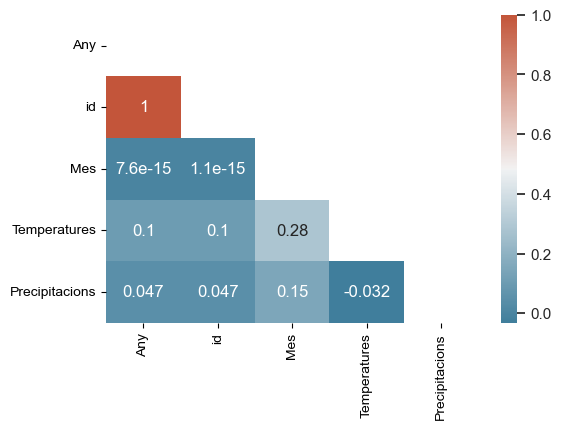

In [32]:
#Correlation matrix
fig,ax = plt.subplots(figsize=(6,4))
corr = df_def.corr()
sns.set_theme(style="white")
cmap = sns.diverging_palette(230, 20, as_cmap=True)

matrix = np.triu(corr)
sns.heatmap(corr, annot=True, mask=matrix, cmap=cmap)
plt.show()

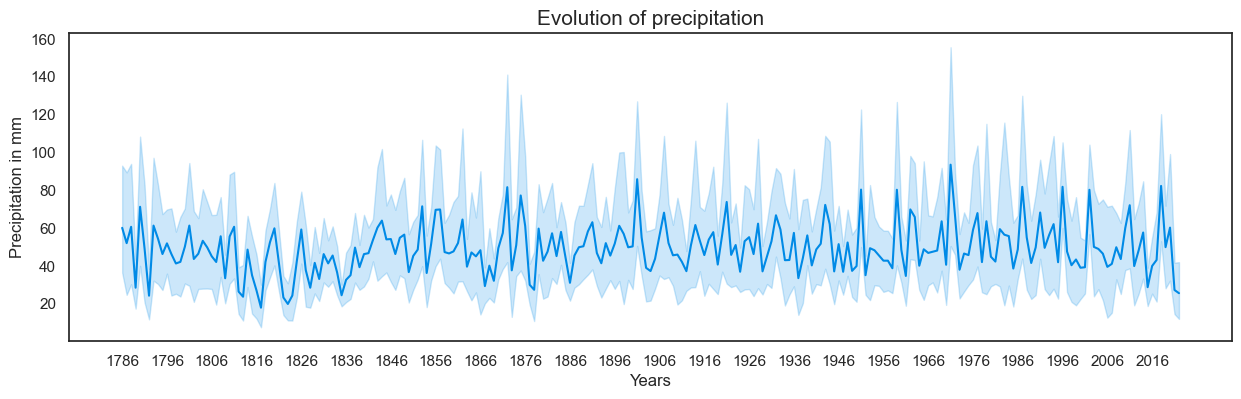

In [33]:
plt.figure(figsize =(15, 4))
sns.lineplot(x=df_def['Any'],y=df_def['Precipitacions'], color='#008ae6')
x = df['Any'].unique()
plt.xticks(np.arange(1786, max(x), 10))

plt.title("Evolution of precipitation",fontsize=15)
plt.xlabel("Years",fontsize=12)
plt.ylabel("Precipitation in mm",fontsize=12)
plt.show()

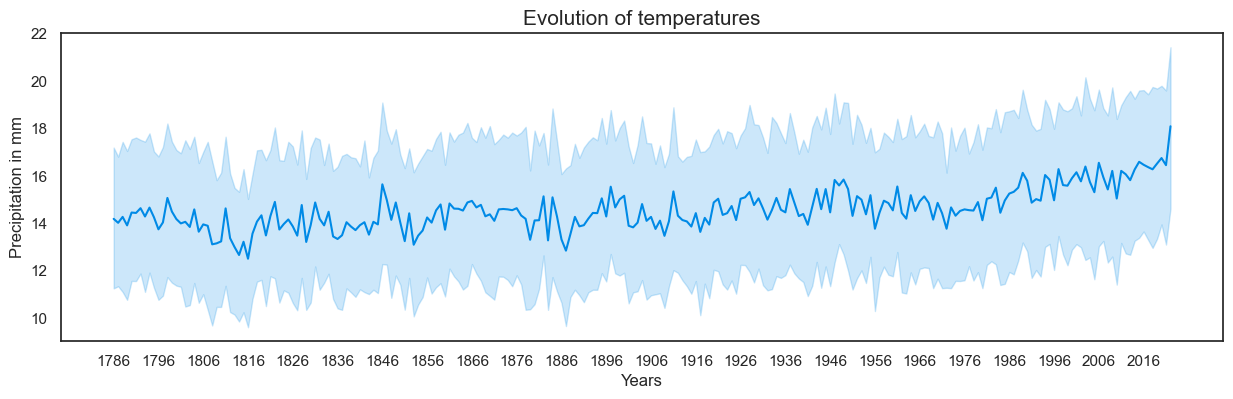

In [34]:
plt.figure(figsize =(15, 4))
sns.lineplot(x=df_def['Any'],y=df_def['Temperatures'], color='#008ae6')
x = df['Any'].unique()
plt.xticks(np.arange(1786, max(x), 10))

plt.title("Evolution of temperatures",fontsize=15)
plt.xlabel("Years",fontsize=12)
plt.ylabel("Precipitation in mm",fontsize=12)
plt.show()

In [35]:
from statsmodels.tsa.stattools import adfuller

In [36]:
#statistics
results = adfuller(total["Temperatures"])
print(f'ADF Statistic: {results[0]}')
print(f'P-value: {results[1]}')
for key, value in results[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

if results[1]<=0.05:
    print("conclusiones: ======")
    print("Rechazamos la hipotésis nula")
    print("Los datos nos indican que son estacionarios")
else:
    print("Conclusiones: ======")
    print("No se puede rechazar la hipotésis nula")
    print("Los datos nos indican que NO son estacionarios")

ADF Statistic: -0.3480791502246181
P-value: 0.9184134654306406
Critial Values:
   1%, -3.459105583381277
Critial Values:
   5%, -2.8741898504150574
Critial Values:
   10%, -2.5735117958412097
Conclusiones: ======
No se puede rechazar la hipotésis nula
Los datos nos indican que NO son estacionarios


La estadística de prueba de Dickey-Fuller es -0.3480791502246142. El valor p asociado a esta estadística es 0.9184134654306413.

Los valores críticos para diferentes niveles de significancia son los siguientes:

Nivel 1%: -3.459105583381277
Nivel 5%: -2.8741898504150574
Nivel 10%: -2.5735117958412097
Interpretación de los resultados:

El valor de la estadística de prueba de -0.3480791502246142 es mayor que los valores críticos para todos los niveles de significancia (1%, 5% y 10%). Esto sugiere que los datos de la serie temporal no son estacionarios.
El valor p de 0.9184134654306413 es mayor que el nivel de significancia de 0.05 (5%). Esto respalda aún más la no estacionariedad de los datos.
En conclusión, según la prueba de Dickey-Fuller, no hay suficiente evidencia para rechazar la hipótesis nula de no estacionariedad para los datos de la serie temporal proporcionados.

In [37]:
from statsmodels.tsa.seasonal import seasonal_decompose

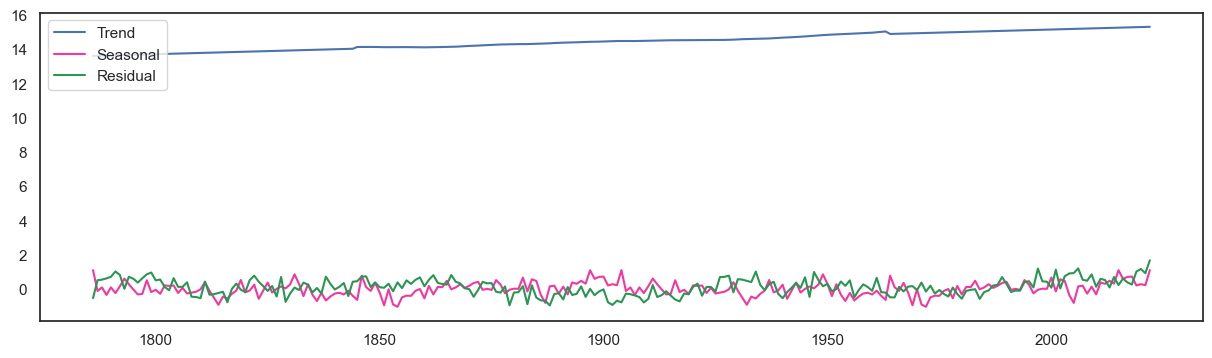

In [38]:
decomposition = seasonal_decompose(total['Temperatures'],model='additive', extrapolate_trend='freq',period = int(len(total)/2) )

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize =(15, 4))
plt.plot(trend,label = 'Trend')
plt.plot(seasonal,label = 'Seasonal', color="#F2389E")
plt.plot(residual,label = 'Residual', color="#2B9553")
plt.legend(loc="upper left")
plt.show()

In [39]:
#statistics

results = adfuller(total["Precipitacions"])
print(f'ADF Statistic: {results[0]}')
print(f'P-value: {results[1]}')
for key, value in results[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

if results[1]<=0.05:
    print("conclusiones: ======")
    print("Rechazamos la hipotésis nula")
    print("Los datos nos indican que son estacionarios")
else:
    print("Conclusiones: ======")
    print("No se puede rechazar la hipotésis nula")
    print("Los datos nos indican que NO son estacionarios")


ADF Statistic: -11.066505124160054
P-value: 4.667187628199031e-20
Critial Values:
   1%, -3.4584868856997004
Critial Values:
   5%, -2.873918902362675
Critial Values:
   10%, -2.573367247623359
conclusiones: ======
Rechazamos la hipotésis nula
Los datos nos indican que son estacionarios


La estadística de prueba de Dickey-Fuller es -11.066505124160058. El valor p asociado a esta estadística es 4.667187628199031e-20.

Los valores críticos para diferentes niveles de significancia son los siguientes:

Nivel 1%: -3.4584868856997004
Nivel 5%: -2.873918902362675
Nivel 10%: -2.573367247623359
Interpretación de los resultados:

El valor de la estadística de prueba de -11.066505124160058 es mucho menor que los valores críticos para todos los niveles de significancia (1%, 5% y 10%). Esto sugiere que los datos de la serie temporal son estacionarios.
El valor p extremadamente pequeño de 4.667187628199031e-20 es mucho menor que el nivel de significancia de 0.05 (5%). Esto respalda aún más la estacionariedad de los datos.
En conclusión, según la prueba de Dickey-Fuller, hay suficiente evidencia para rechazar la hipótesis nula de no estacionariedad para los datos de la serie temporal proporcionados. Por lo tanto, los datos se consideran estacionarios.

PRECIPITACIONES   estacionaria table

TEMPERATURA No estacionaria table1

In [40]:
!pip install statsforecast

In [41]:
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA, ETS, Naive
from statsforecast.arima import arima_string

In [42]:
#In google colab we should install pmdarima in order to use it.
!pip install pmdarima

In [43]:
table1["unique_id"]= "1"
table1 = table1.rename(columns = {'Data': "ds", 'value':"y"})

table1.head()

,Any,id,variable,y,ds,unique_id
0,1786,1,1,7.8,1786-01-01,1
1,1787,2,1,5.4,1787-01-01,1
2,1788,3,1,6.4,1788-01-01,1
3,1789,4,1,6.9,1789-01-01,1
4,1790,5,1,7.4,1790-01-01,1


In [45]:
# División de los datos en entrenamiento y prueba. Para los datos de prueba usaremos los 60 últimos meses para realizar la prueba y evaluación del desempeño de nuestro modelo.
y_train_df = table1[table1.ds<='2017-01-01']
y_test_df = table1[table1.ds>'2017-01-01']
y_train_df.shape, y_test_df.shape

((2773, 6), (71, 6))

In [46]:
season_length = 60
horizon = len(y_test_df)

In [51]:
# llamamos al model
models = [
    AutoARIMA(season_length=season_length),
    ETS(season_length=season_length),
    Naive()
]

In [54]:
sf = StatsForecast(
    df=y_train_df,
    models=models,
    freq='MS', 
    n_jobs=-1
)